In [218]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [219]:
file_path = "data\\hands2D.mat"
x=0
with h5py.File(file_path, 'r') as mat_file:
    for key in mat_file.keys():
        print(f"Dataset: {key}, Shape: {mat_file[key].shape}")
        x=mat_file[key].shape[0]
    print(mat_file.keys())

Dataset: shapes, Shape: (40, 56, 2)
<KeysViewHDF5 ['shapes']>


In [220]:
file_path = "data\\hands2D.mat"
pointsets=[]
with h5py.File(file_path, 'r') as mat_file:
    data = mat_file['shapes']
    for p in data:
        pointsets.append(np.array(p).T)

In [221]:
print(len(pointsets))
print(pointsets[0].shape)

40
(2, 56)


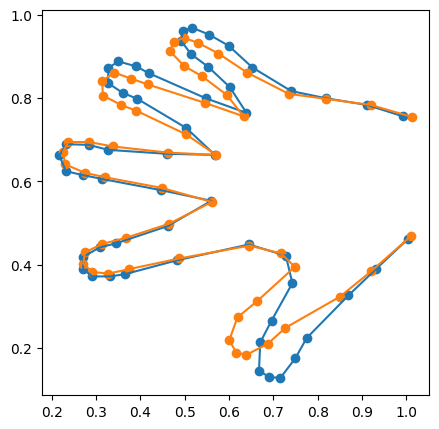

In [222]:
plt.figure(figsize=(5, 5))
plt.plot(pointsets[0][0], pointsets[0][1])
plt.scatter(pointsets[0][0], pointsets[0][1])
plt.plot(pointsets[1][0], pointsets[1][1])
plt.scatter(pointsets[1][0], pointsets[1][1])

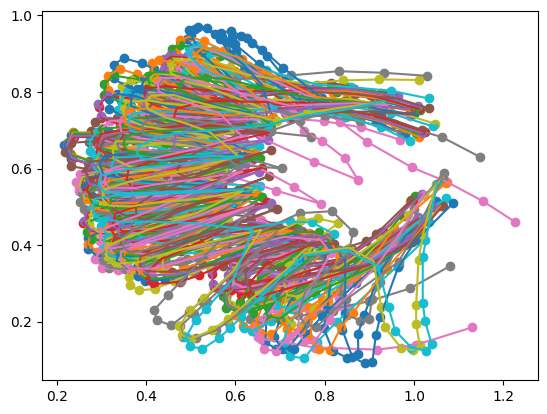

In [223]:
for i in range(40):
    # plt.figure(figsize=(5, 5))
    plt.plot(pointsets[i][0], pointsets[i][1])
    plt.scatter(pointsets[i][0], pointsets[i][1])

Text(0.5, 1.0, 'Pointset 2')

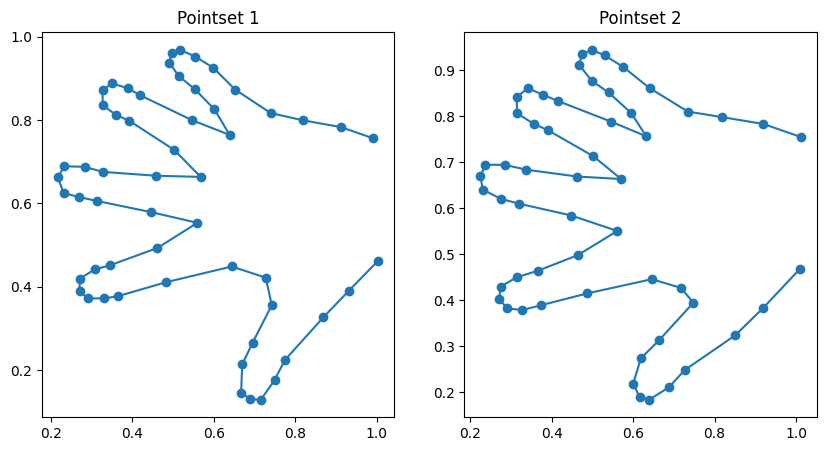

In [224]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(pointsets[0][0], pointsets[0][1])
plt.scatter(pointsets[0][0], pointsets[0][1])
plt.title('Pointset 1')

plt.subplot(1, 2, 2)
plt.plot(pointsets[1][0], pointsets[1][1])
plt.scatter(pointsets[1][0], pointsets[1][1])
plt.title('Pointset 2')

In [225]:
#Finding the karcher mean__CODE22
def centroid_normalize(shape):
    centered_shape = shape - np.mean(shape, axis=1, keepdims=True)
    norm = np.linalg.norm(centered_shape,'fro')
    normalized_shape = centered_shape / norm if norm != 0 else centered_shape
    # print(normalized_shape.shape)
    return normalized_shape

def best_rotation(A, B):
    # print(B.shape)
    U, S, Vt = np.linalg.svd(B @ A.T)
    R = U @ Vt
    if np.linalg.det(R) < 0:
        U[:, -1] *= -1
        R = U @ Vt
    scale = np.trace(A.T @ R @ B) / np.trace(B.T @ B)
    translation = np.mean(A - scale * R @ B, axis=1, keepdims=True)
    return scale, R, translation


In [226]:
def compute_karcher_mean(pointsets, max_iter=30, tol=1e-6):
    pointsets_array = np.array(pointsets)  # Shape: (n_shapes, 2, 56)
    n_shape = pointsets_array.shape[0] # 40
    for i in range(n_shape):
        pointsets_array[i] = centroid_normalize(pointsets_array[i])
    mean_shape = np.mean(pointsets_array, axis=0)
    mean_shape = centroid_normalize(mean_shape)

    for iter in range(max_iter):
        aligned_shapes = []
        for i in range(n_shape):
            s, R,t = best_rotation(mean_shape, pointsets_array[i])
            aligned = R @ pointsets_array[i]
            aligned_shapes.append(aligned)

        new_mean = np.mean(np.stack(aligned_shapes), axis=0)
        new_mean = centroid_normalize(new_mean)

        diff = np.linalg.norm(new_mean - mean_shape)
        if diff < tol:
            print(f"Converged in {iter+1} iterations.")
            break
        mean_shape = new_mean

    return mean_shape, aligned_shapes

Text(0.5, 1.0, 'Karcher Mean using Code_11 (Only Rotation is optimized)')

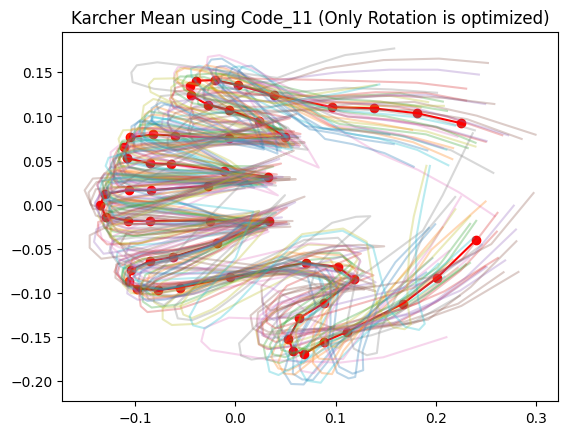

In [227]:
mean_shape, aligned_shapes_code11=compute_karcher_mean(pointsets)
plt.plot(mean_shape[0], mean_shape[1], color='red')
plt.scatter(mean_shape[0], mean_shape[1], color='red')
for shape in pointsets:
        shape=centroid_normalize(shape)
        plt.plot(shape[0], shape[1], alpha=0.3) 
plt.title('Karcher Mean using Code_11 (Only Rotation is optimized)')

In [228]:
def compute_karcher_mean(pointsets, max_iter=30, tol=1e-6):
    pointsets_array = np.array(pointsets)  # Shape: (n_shapes, 2, 56)
    n_shape = pointsets_array.shape[0] # 40
    for i in range(n_shape):
        pointsets_array[i] = centroid_normalize(pointsets_array[i])
    mean_shape = np.mean(pointsets_array, axis=0)
    mean_shape = centroid_normalize(mean_shape)

    for iter in range(max_iter):
        aligned_shapes = []
        for i in range(n_shape):
            s, R,t = best_rotation(mean_shape, pointsets_array[i])
            aligned = s*R @ pointsets_array[i]+t
            aligned_shapes.append(aligned)

        new_mean = np.mean(np.stack(aligned_shapes), axis=0)
        new_mean = centroid_normalize(new_mean)

        diff = np.linalg.norm(new_mean - mean_shape)
        if diff < tol:
            print(f"Converged in {iter+1} iterations.")
            break
        mean_shape = new_mean

    return mean_shape, aligned_shapes

Text(0.5, 1.0, 'Karcher Mean using Code_22')

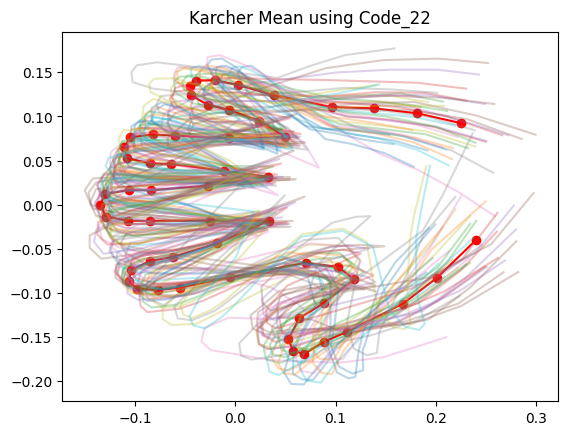

In [229]:
mean_shape_2,aligned_shapes_code22=compute_karcher_mean(pointsets)
plt.plot(mean_shape[0], mean_shape[1], color='red')
plt.scatter(mean_shape[0], mean_shape[1], color='red')
for shape in pointsets:
        shape=centroid_normalize(shape)
        plt.plot(shape[0], shape[1], alpha=0.3) 
plt.title('Karcher Mean using Code_22')

In [230]:
#Part C
def pca_shape_variation(aligned_shapes):
    n_shapes = len(aligned_shapes)
    # Step 1: Flatten each shape to (112,)
    flat_shapes = [shape.flatten() for shape in aligned_shapes]
    data_matrix = np.stack(flat_shapes)  # Shape: (n_shapes, 112)

    # Step 2: Mean shape vector
    mean_vec = np.mean(data_matrix, axis=0)

    # Step 3: Center the data
    centered_data = data_matrix - mean_vec

    # Step 4: Covariance matrix
    cov = np.cov(centered_data, rowvar=False)

    # Step 5: Eigen decomposition
    eigvals, eigvecs = np.linalg.eigh(cov)
    sorted_indices = np.argsort(eigvals)[::-1]
    eigvals = eigvals[sorted_indices]
    eigvecs = eigvecs[:, sorted_indices]

    return eigvals, eigvecs


In [ ]:
eigvals11, eigvecs11 = pca_shape_variation(aligned_shapes_code11)
eigvals22, eigvecs22 = pca_shape_variation(aligned_shapes_code22)

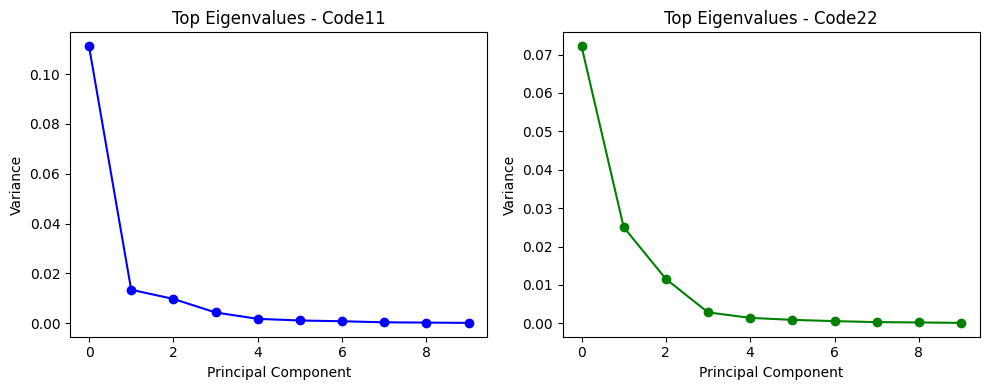

In [232]:
plt.figure(figsize=(10, 4))

# Code11
plt.subplot(1, 2, 1)
plt.plot(eigvals11[:10], marker='o', color='blue')
plt.title("Top Eigenvalues - Code11")
plt.xlabel("Principal Component")
plt.ylabel("Variance")

# Code22
plt.subplot(1, 2, 2)
plt.plot(eigvals22[:10], marker='o', color='green')
plt.title("Top Eigenvalues - Code22")
plt.xlabel("Principal Component")
plt.ylabel("Variance")

plt.tight_layout()
plt.show()


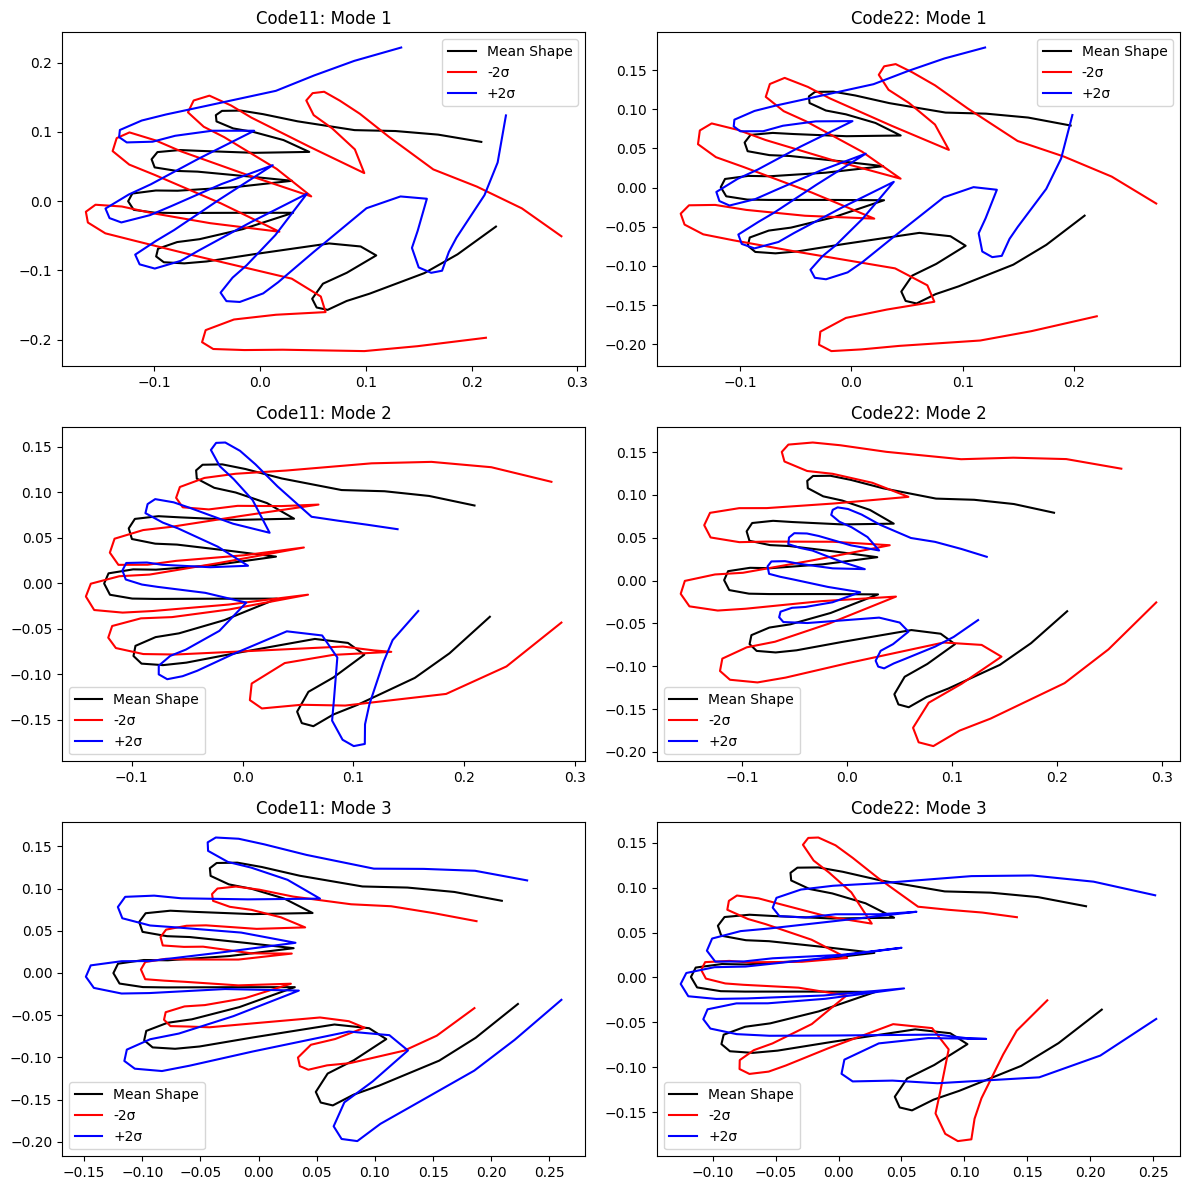

In [233]:
#Part D
import numpy as np
import matplotlib.pyplot as plt

def compute_shape_covariance(aligned_shapes):
    """
    Compute the shape covariance matrix from aligned pointsets.
    Each shape is flattened into a vector before computing covariance.
    """
    n_shapes = len(aligned_shapes)
    shape_dim = aligned_shapes[0].shape  # (2, 56)
    
    # Flatten each shape into a 1D vector of length (2*56)
    flattened_shapes = np.array([shape.flatten() for shape in aligned_shapes])
    
    # Compute mean and covariance matrix
    mean_vector = np.mean(flattened_shapes, axis=0)
    covariance_matrix = np.cov(flattened_shapes.T)
    
    return mean_vector.reshape(shape_dim), covariance_matrix

def compute_principal_modes(covariance_matrix):
    """
    Perform eigen decomposition of the covariance matrix to get principal modes.
    Returns sorted eigenvalues and corresponding eigenvectors.
    """
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    
    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    return eigenvalues[sorted_indices], eigenvectors[:, sorted_indices]

def generate_variations(mean_shape, eigenvalues, eigenvectors, std_multipliers=[2, -2]):
    """
    Generate new shapes by perturbing the mean shape along principal modes.
    """
    variations = []
    for mode in range(3):  # Top 3 modes
        mode_vector = eigenvectors[:, mode].reshape(mean_shape.shape)
        for std in std_multipliers:
            variations.append(mean_shape + std * np.sqrt(eigenvalues[mode]) * mode_vector)
    return variations

# Compute covariance and eigen decomposition
mean_shape_code11, covariance_code11 = compute_shape_covariance(aligned_shapes_code11)
mean_shape_code22, covariance_code22 = compute_shape_covariance(aligned_shapes_code22)

eigenvalues_11, eigenvectors_11 = compute_principal_modes(covariance_code11)
eigenvalues_22, eigenvectors_22 = compute_principal_modes(covariance_code22)

# Generate new shapes for visualization
variations_11 = generate_variations(mean_shape_code11, eigenvalues_11, eigenvectors_11, std_multipliers=[-2, 2])
variations_22 = generate_variations(mean_shape_code22, eigenvalues_22, eigenvectors_22, std_multipliers=[-2, 2])

# Plot results
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
titles = ['Code11: Mode 1', 'Code22: Mode 1', 'Code11: Mode 2', 'Code22: Mode 2', 'Code11: Mode 3', 'Code22: Mode 3']

for i in range(3):
    axes[i, 0].plot(mean_shape_code11[0], mean_shape_code11[1], 'k-', label="Mean Shape")
    axes[i, 0].plot(variations_11[2*i][0], variations_11[2*i][1], 'r-', label="-2σ")
    axes[i, 0].plot(variations_11[2*i+1][0], variations_11[2*i+1][1], 'b-', label="+2σ")
    axes[i, 0].set_title(titles[2*i])
    axes[i, 0].legend()
    
    axes[i, 1].plot(mean_shape_code22[0], mean_shape_code22[1], 'k-', label="Mean Shape")
    axes[i, 1].plot(variations_22[2*i][0], variations_22[2*i][1], 'r-', label="-2σ")
    axes[i, 1].plot(variations_22[2*i+1][0], variations_22[2*i+1][1], 'b-', label="+2σ")
    axes[i, 1].set_title(titles[2*i+1])
    axes[i, 1].legend()

plt.tight_layout()
plt.show()
